# This notebook fine-tunes the BERT model used for choosing between the candidates of the next sentence

## Importing Required Components

In [1]:
import torch
import random
import pickle
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AdamW, BertForNextSentencePrediction, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

## Some Preparations

In [2]:
%matplotlib inline

random.seed(17)
np.random.seed(17)
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

## Reading Dataset

In [ ]:
df = pd.read_csv("data.csv")
raps = df["rap"].values.tolist()
rappers = df["rapper"].unique().tolist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Configuring Tokenizer and Model Config

In [ ]:
model_name = "HooshvareLab/bert-base-parsbert-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForNextSentencePrediction.from_pretrained(model_name)
model.to(device)

## Converting Raw Data to Torch Dataset

In [5]:
def create_pairs_from_orig_data(raps):
    pairs = []

    for rap in raps:
        rap_sentences = rap.split("<sep>")
        num_of_sentences = len(rap_sentences)
        num_of_zeros, num_of_ones = 0, 0
        for i, j in itertools.permutations(range(num_of_sentences), 2):
            if j == i + 1:
                pairs.append([rap_sentences[i], rap_sentences[j], 0])
                pairs.append([rap_sentences[i], rap_sentences[j], 0])
                num_of_zeros += 1
            elif num_of_ones < num_of_sentences * 2:
                pairs.append([rap_sentences[i], rap_sentences[j], 1])
                num_of_ones += 1
            if num_of_zeros == int(num_of_sentences):
                break

    return pairs


def create_dataset_from_pairs(pairs):
    input_ids, token_type_ids, attention_mask, labels = [], [], [], []

    for pair in pairs:
        sentence1, sentence2, label = pair
        encoding = tokenizer.encode_plus(sentence1, sentence2,
                                         add_special_tokens=True,
                                         max_length=128,
                                         padding="max_length",
                                         return_tensors="pt")

        input_ids.append(encoding["input_ids"])
        token_type_ids.append(encoding["token_type_ids"])
        attention_mask.append(encoding["attention_mask"])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    labels = torch.tensor(labels)

    return TensorDataset(input_ids, token_type_ids, attention_mask, labels)

def get_train_val_datasets(ds, val_size=512):
    train_ds, val_ds = random_split(ds, [len(ds) - val_size, val_size])
    return train_ds, val_ds

def read_pickle_data(addr, mode="rb"):
    with open(addr, mode) as file:
        data = pickle.load(file)

    return data

def write_pickle_data(addr, data, mode="wb"):
    with open(addr, mode) as file:
        pickle.dump(data, file)

## Calling The Above Functions

In [ ]:
pairs = create_pairs_from_orig_data(raps)
ds = create_dataset_from_pairs(pairs)
write_pickle_data("data/bert_ds.pickle", ds)
# ds = read_pickle_data("data/bert_ds.pickle")
train_ds, val_ds = get_train_val_datasets(ds)

## Configuring Train and Validation Dataloaders

In [8]:
batch_size = 32
num_samples = 15000

train_dataloader = DataLoader(
    train_ds,
    sampler=RandomSampler(train_ds, num_samples=num_samples),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_ds,
    sampler=SequentialSampler(val_ds),
    batch_size=batch_size
)

## Configuring Optimizer and Scheduler

In [9]:
epochs = 5
learning_rate = 8e-6

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, no_deprecation_warning=True)
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

## Training and Evaluating the Model

Epoch: 1
Step 0 Passed.
Step 250 Passed.
Epoch Validation Loss: 0.5082293581217527
Epoch Train Loss: 0.5153779146958516
Epoch: 2
Step 0 Passed.
Step 250 Passed.
Epoch Validation Loss: 0.4746099002659321
Epoch Train Loss: 0.4709767334496797
Epoch: 3
Step 0 Passed.
Step 250 Passed.
Epoch Validation Loss: 0.4465049933642149
Epoch Train Loss: 0.4502413380247698
Epoch: 4
Step 0 Passed.
Step 250 Passed.
Epoch Validation Loss: 0.40503902919590473
Epoch Train Loss: 0.42310934493155367
Epoch: 5
Step 0 Passed.
Step 250 Passed.
Epoch Validation Loss: 0.3900621421635151
Epoch Train Loss: 0.3983596551265798


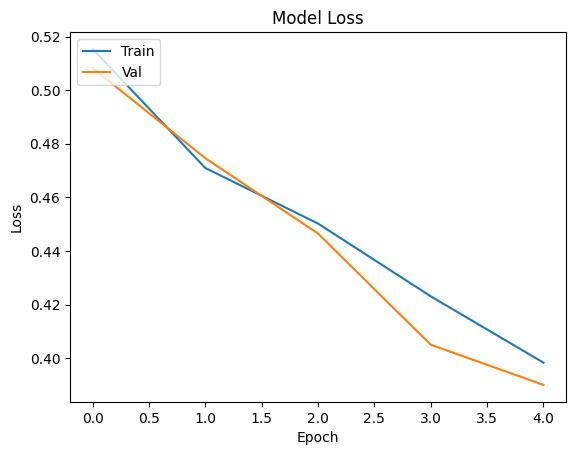

In [10]:
train_losses, val_losses = [], []

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    # Train Phase
    train_loss = 0
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_token_type_ids = batch[1].to(device)
        batch_attention_mask = batch[2].to(device)
        batch_labels = batch[3].to(device)

        model.zero_grad()

        res = model(batch_input_ids,
                    token_type_ids=batch_token_type_ids,
                    attention_mask=batch_attention_mask,
                    labels=batch_labels,
                    return_dict=True)

        batch_loss = res.loss
        train_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        if step % 250 == 0:
            print(f"Step {step} Passed.")

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Evaluation Phase
    val_loss = 0
    model.eval()
    for batch in val_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_token_type_ids = batch[1].to(device)
        batch_attention_mask = batch[2].to(device)
        batch_labels = batch[3].to(device)

        with torch.no_grad():
            res = model(batch_input_ids,
                        token_type_ids=batch_token_type_ids,
                        attention_mask=batch_attention_mask,
                        labels=batch_labels,
                        return_dict=True)

            batch_loss = res.loss
            val_loss += batch_loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch Validation Loss: {avg_val_loss}")
    print(f"Epoch Train Loss: {avg_train_loss}")


# Plotting Train and Validation Loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Saving The Model To The Disk

In [12]:
# model.save_pretrained("models/bert_model")